<a href="https://colab.research.google.com/github/charmzshab/DataScience-Blogs/blob/master/faiss_similarity_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('faiss-similarity-search')
jovian.set_colab_id('149juzQ-2f_G8dqs2erSpwFXduGPeNE5q')

     |████████████████████████████████| 68 kB 4.3 MB/s 


# Choosing Indexes for Similarity Search (FAISS in Python)

> Indented block



Use the "Run" button to execute the code.

In [2]:
!pip install jovian --upgrade --quiet

In [3]:
import jovian

In [4]:
# Execute this to save new versions of the notebook
jovian.commit(project="faiss-similarity-search")

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/charmzshab-0vn/faiss-similarity-search


'https://jovian.ai/charmzshab-0vn/faiss-similarity-search'

In [5]:
# getting Sift1M Data

import shutil
import urllib.request as request
from contextlib import closing

with closing(request.urlopen('ftp://ftp.irisa.fr/local/texmex/corpus/sift.tar.gz')) as r:
  with open('sift.tar.gz','wb') as f:
    shutil.copyfileobj(r,f)


In [6]:
import tarfile

tar = tarfile.open('sift.tar.gz',"r:gz")
tar.extractall()

In [7]:
import numpy as np

def read_fvecs(fp):
  a = np.fromfile(fp,dtype='int32')
  d = a[0]
  return a.reshape(-1,d + 1)[:,1:].copy().view('float32')

In [8]:
#  data we will search through
wb = read_fvecs('./sift/sift_base.fvecs') # 1M

xq = read_fvecs('./sift/sift_query.fvecs')

# take just one query (there are many queries in sift_learn_fvecs)
xq = xq[0].reshape(1,xq.shape[1])

In [9]:
xq.shape

(1, 128)

In [10]:
wb.shape

(1000000, 128)

#IndexFlatL2
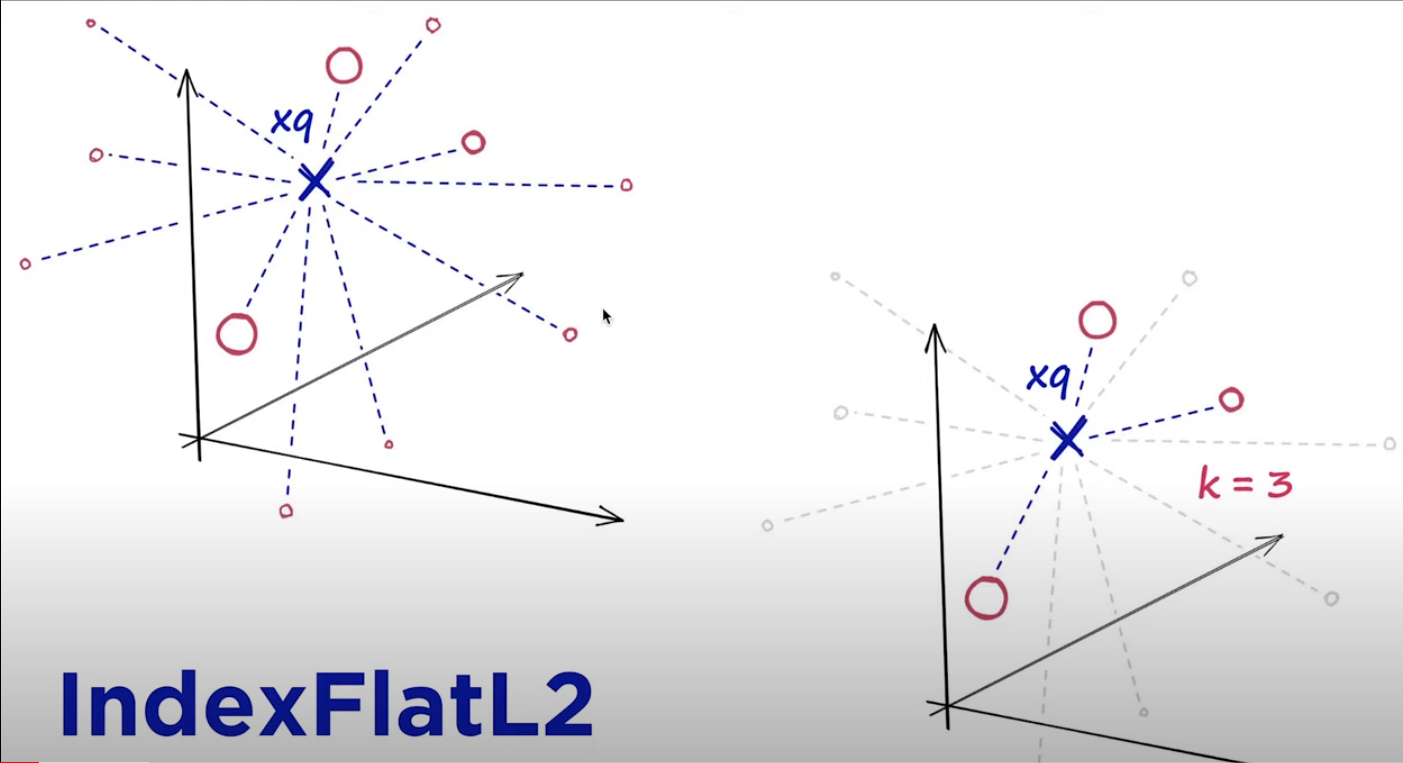


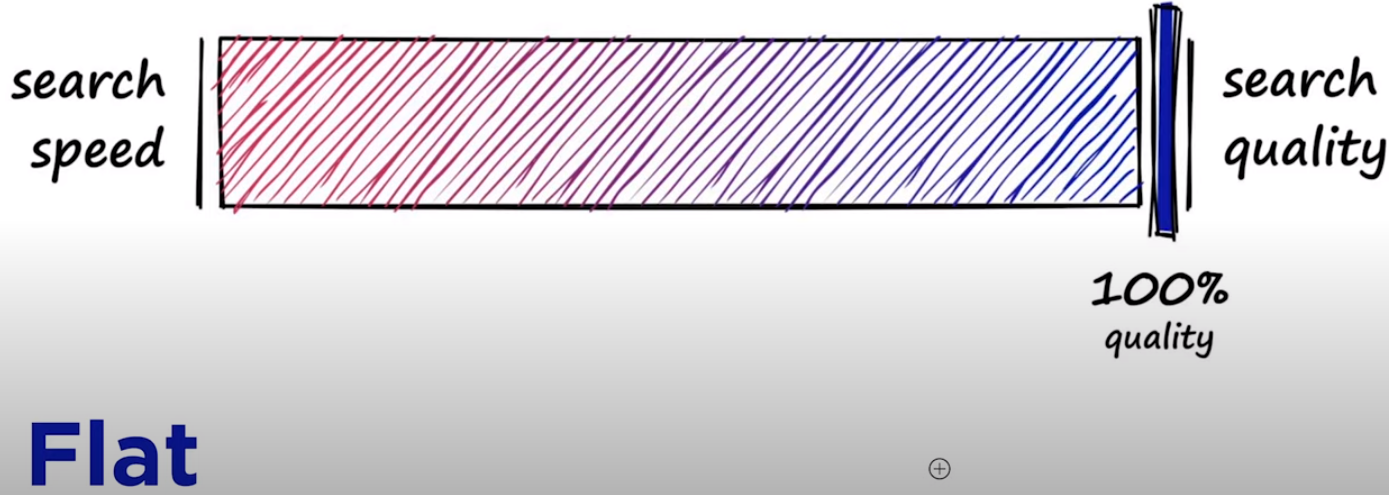

In [14]:
!pip install faiss

In [15]:
!pip install faiss_gpu

In [16]:
# dimensinality of the data
d = 128
k = 10

import faiss

index = faiss.IndexFlatIP(d)
index.add(wb)


In [17]:
%%time
D, I = index.search(xq, k)

CPU times: user 144 ms, sys: 0 ns, total: 144 ms
Wall time: 132 ms


In [19]:
# [f'{i}:{lines[i]}' for i in I[0]]
I

array([932085, 934876, 561813, 708177, 706771, 695756, 435345, 701258,
       872728, 455537])

In [20]:
baseline = I[0].tolist()
baseline

[932085,
 934876,
 561813,
 708177,
 706771,
 695756,
 435345,
 701258,
 872728,
 455537]

#Other indexes that atleast strike a balance

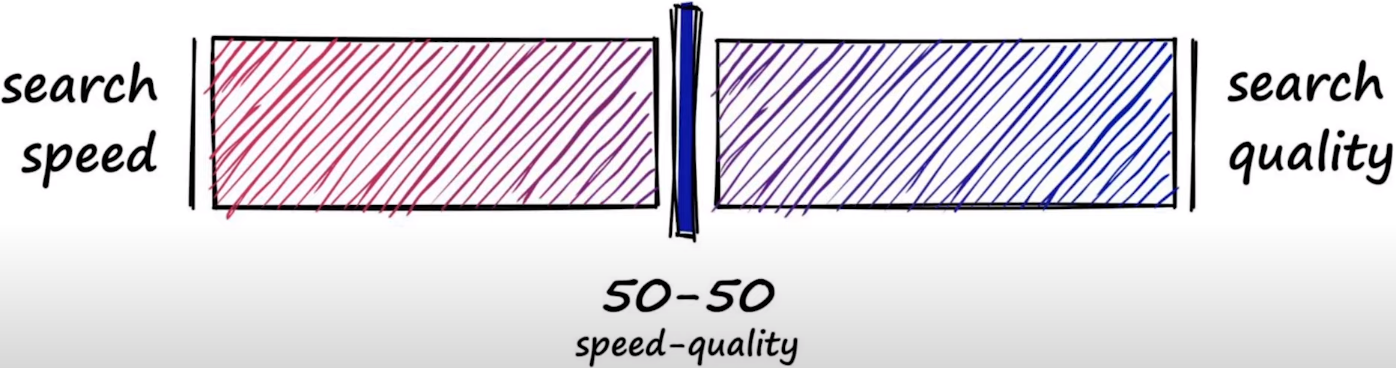

#Locality Sensitive Hashing (LSH)

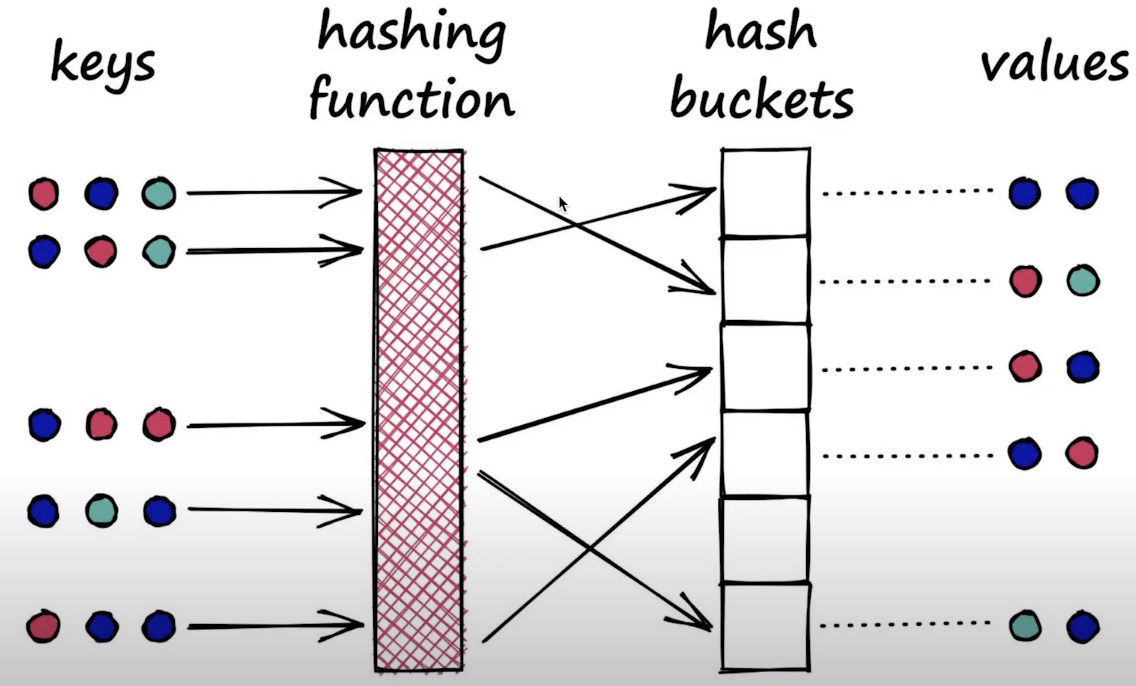

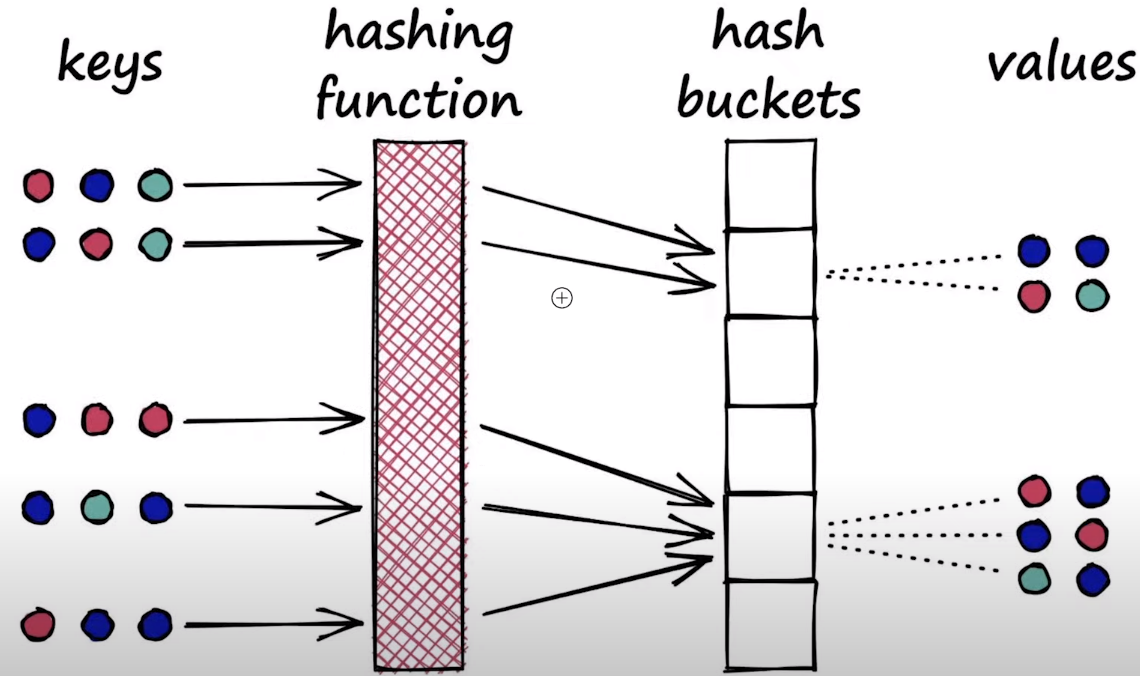

In [21]:
nbits = d*4

index = faiss.IndexLSH(d,nbits)
index.add(wb)

In [23]:
%%time
D,I = index.search(xq,k)

CPU times: user 60 ms, sys: 0 ns, total: 60 ms
Wall time: 35.8 ms


In [34]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/charmzshab-0vn/faiss-similarity-search


'https://jovian.ai/charmzshab-0vn/faiss-similarity-search'

In [25]:
# compare the results(LSH) to the 100% quality index(IndexFlatIP)
np.in1d(baseline,I)



array([ True,  True,  True,  True, False, False,  True, False, False,
        True])

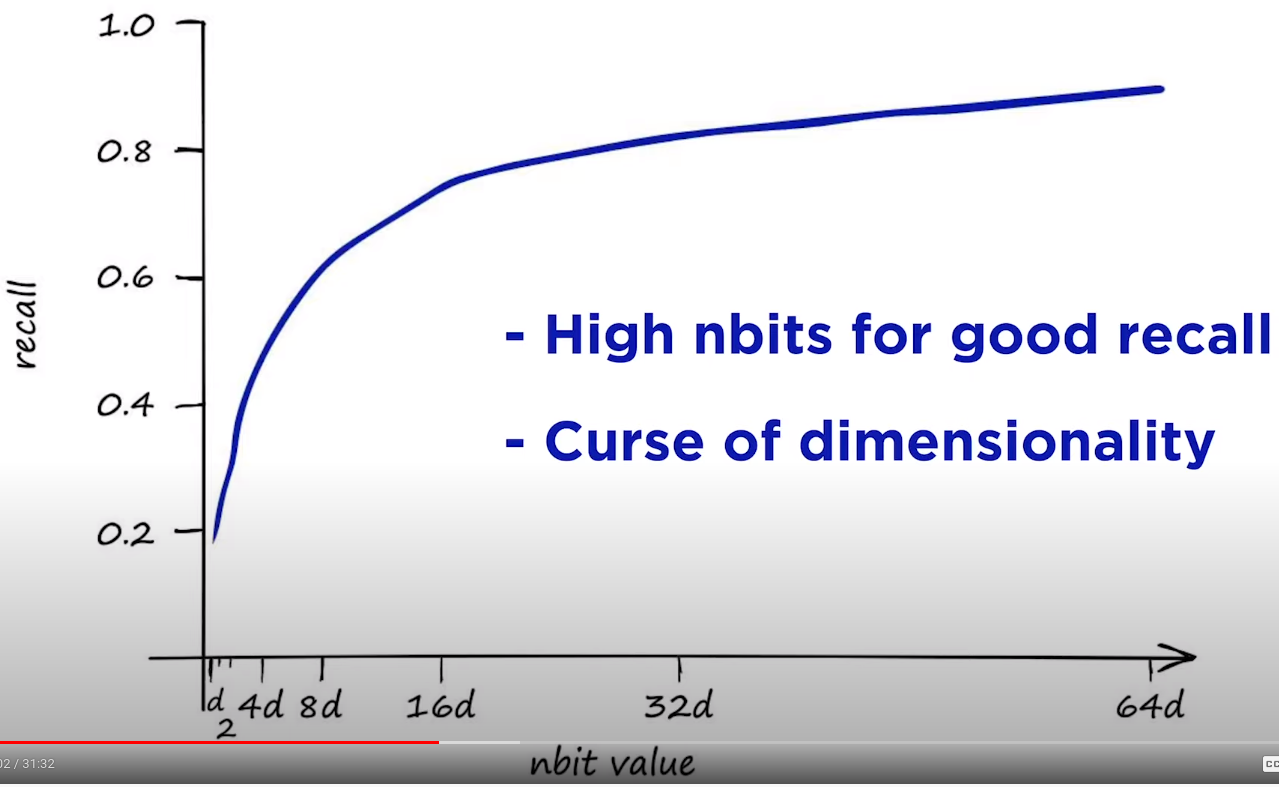

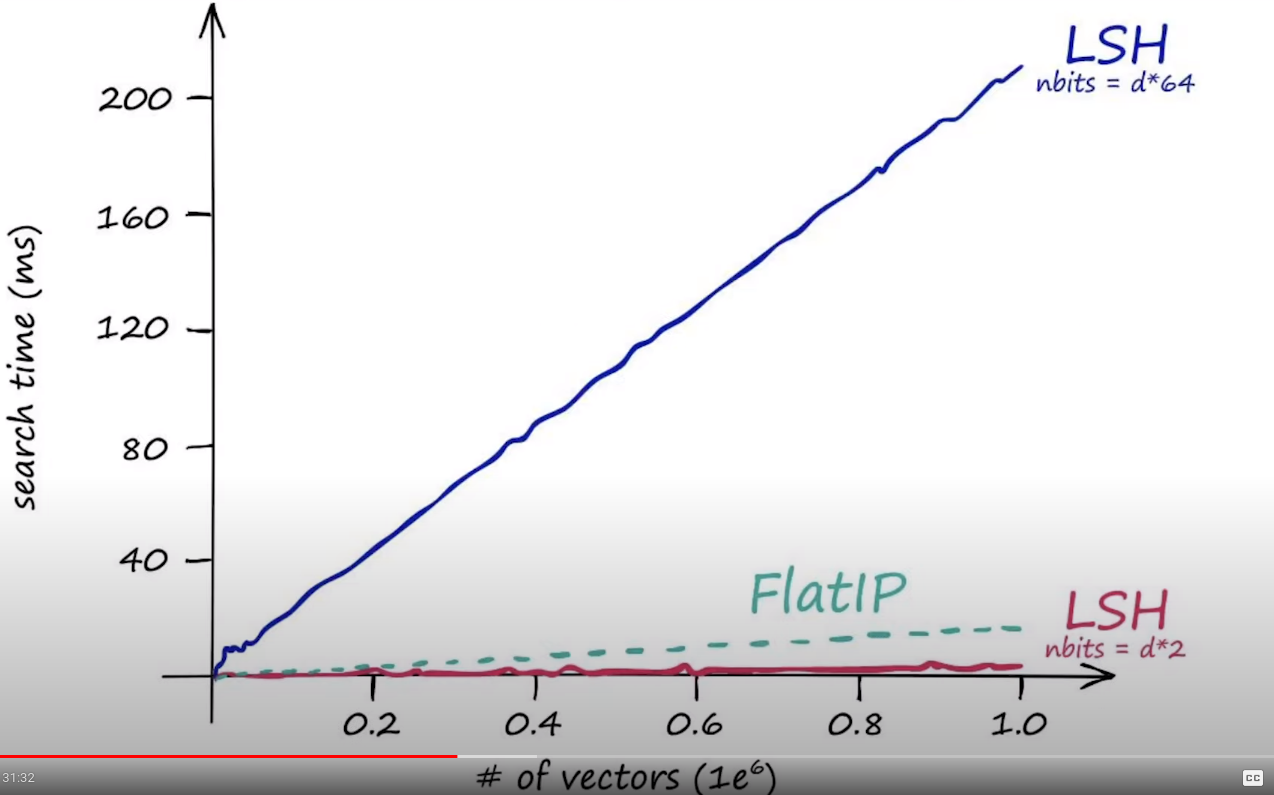

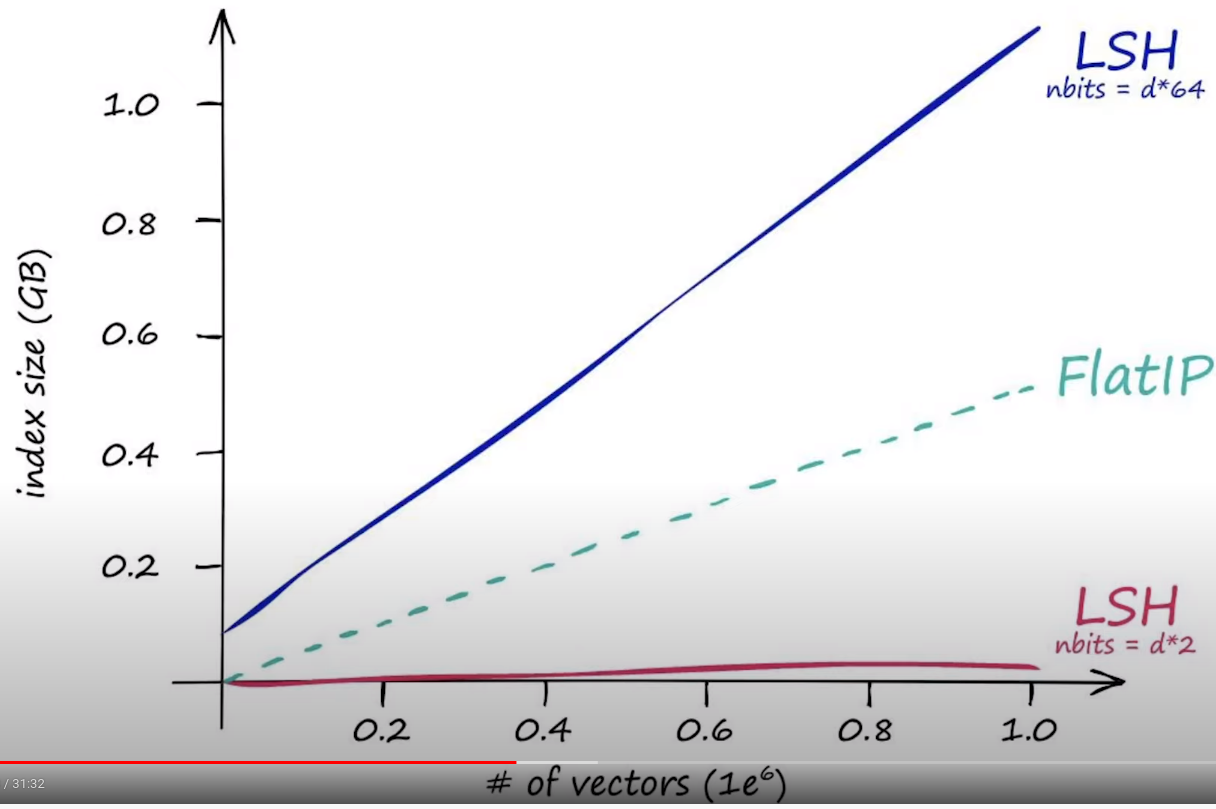

Fig1:Graph of recall with different nbit values => we increase nbit values for a good recall but at the same time the curse of dimensionality[lower dimensinality is very good for LSH]

Fig2: nbits with dimensionality multiplied by 2 => LSH is super fast(faster than the flat index).
But if u increase nbits values quite abit for a high performance,then it gets out of hand very quickly and our search time grows massively.

Fig3: same applies to the index size,low bit size the index size isn't too bad but with high nbits,the index size is huge

#**Hierarchical Navigable Small World (HNSW)**

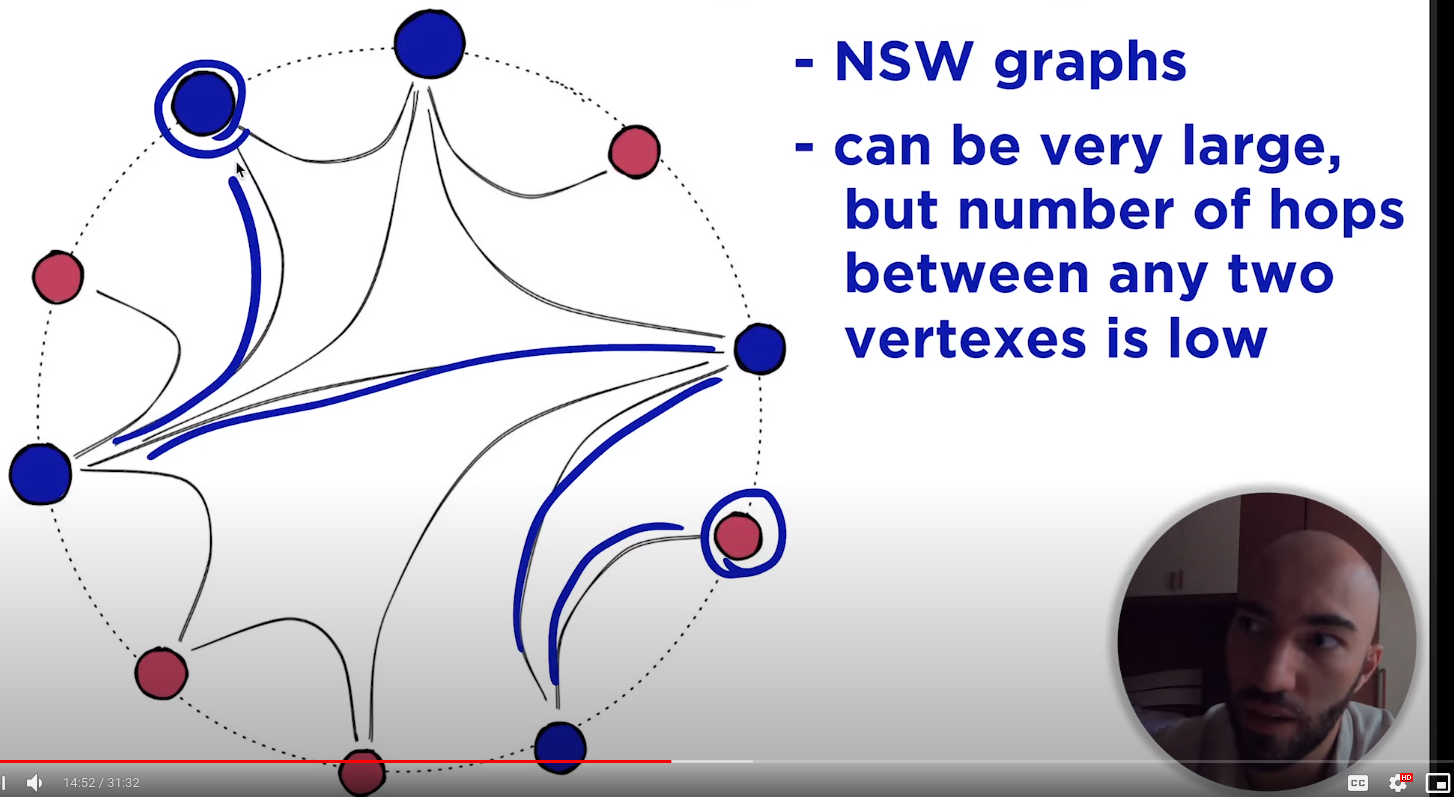

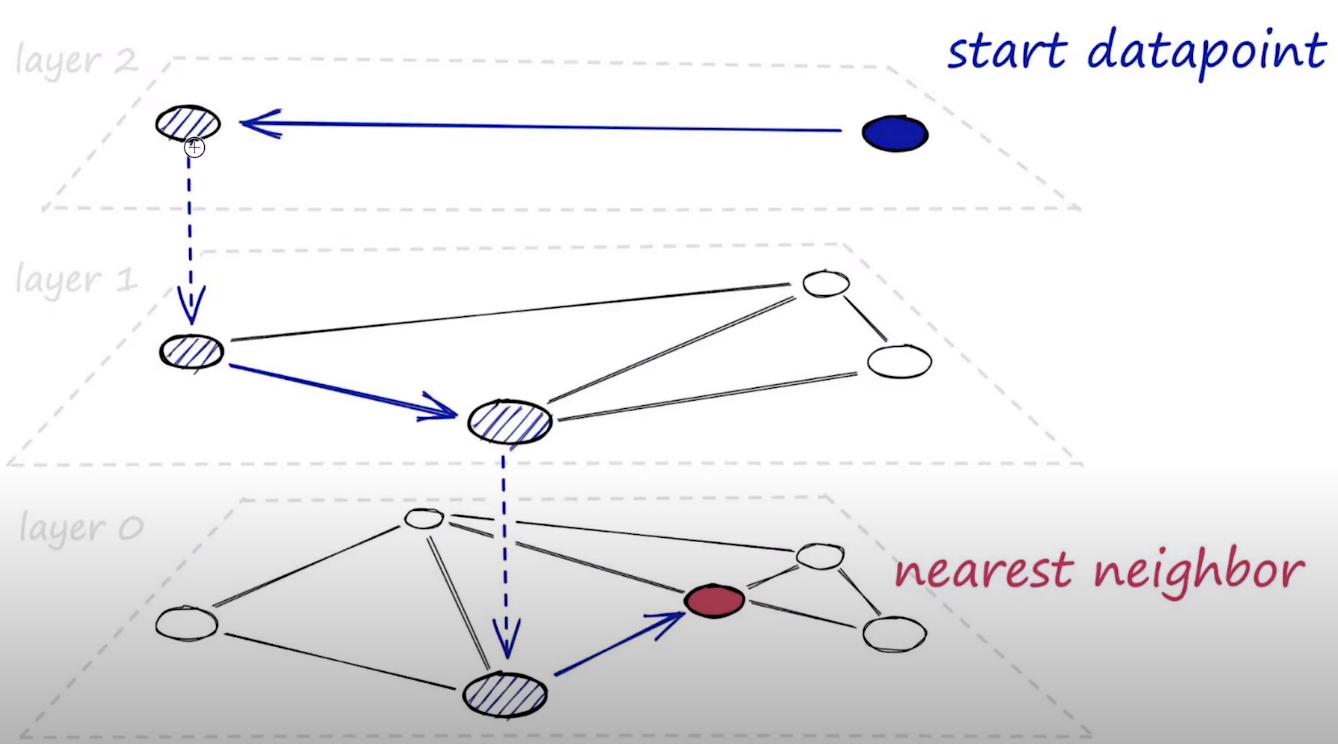

In [30]:
# number of connections that each vertex has
M = 32

# what's the depth of search,everytime we perform search
# set it to high value if we want to search more for the network ==> more accurate
# set it to low value if we want to search less for the network ==> quicker!
ef_search = 32 

# how much of the network will be searched
# not during actual search but rather during 
# construction of the network ==> how accurately we going to build the network
# will icrease the ad time but won't make any difference in the search time
ef_construction = 64

In [31]:
index = faiss.IndexHNSWFlat(d,M)

index.hnsw.efSearch = ef_search

index.hnsw.efConstruction = ef_construction

index.add(wb)

In [32]:
%%time
D,I = index.search(xq,k)

CPU times: user 5.22 ms, sys: 0 ns, total: 5.22 ms
Wall time: 6.08 ms


In [33]:
np.in1d(baseline,I)

array([ True,  True,  True,  True,  True,  True, False,  True,  True,
        True])